# 项目背景介绍
通过对数据集的训练，从而使模型具备识别眼睛和嘴的开闭状态，据此可评估人员精神状态。

# 前处理

解压数据集

![](https://ai-studio-static-online.cdn.bcebos.com/2942133e313a4a31b765d1ae5042e2908471172a923e4d17898df1697b109e60)



In [ ]:
#解压缩数据集到Dataset目录
!unzip /home/aistudio/data/data105521/Fatigue.zip -d ./Dataset

处理数据集

In [ ]:
#安装paddlex
! pip install paddlex==2.0.0rc4 -i https://mirror.baidu.com/pypi/simple

Looking in indexes: https://mirror.baidu.com/pypi/simple
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [1]:
import os,shutil
#指定图片数据
jpeg = 'Dataset/dataset/JPEGImages'
jpeg_list = os.listdir(jpeg)
#指定标签数据
anno = 'Dataset/dataset/Annotations'
anno_list = os.listdir(anno)
#清除不对应数据
for pic in jpeg_list:
    name = pic.split('.')[0]
    anno_name = name + '.xml'
    print(anno_name)
    if anno_name not in anno_list:
        os.remove(os.path.join(jpeg,pic))

In [2]:
#paddlex参数设置
!paddlex --split_dataset --format VOC --dataset_dir Dataset/dataset --val_value 0.2 --test_value 0.1

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/distributed/parallel.py:136: UserWarning: Currently not a parallel execution environment, `paddle.distributed.init_parallel_env` will not do anything.
  "Currently not a parallel execution environment, `paddle.distributed.init_parallel_env` will not do anything."
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddleslim/core/graph_wrapper.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
[02-23 15:25:35 MainThread @logger.py:242] Argv: /opt/conda/envs/python35-paddle120-env/bin/paddlex --split_dataset --format VOC --dataset_dir Dataset/dataset --val_value 0.2 --test_value 0.1
[02-23 15:25:35 MainThread @utils.py:79] WRN paddlepaddle version: 2.2.2. The dynamic graph version of PARL is under development, not fully tested and supported
/opt/conda/envs/python

In [3]:
import paddlex as pdx
from paddlex import transforms as T
#数据增强
train_transforms = T.Compose([
    T.MixupImage(mixup_epoch=-1), T.RandomDistort(),
    T.RandomExpand(im_padding_value=[123.675, 116.28, 103.53]), T.RandomCrop(),
    T.RandomHorizontalFlip(), T.BatchRandomResize(
        target_sizes=[
            320, 352, 384, 416, 448, 480, 512, 544, 576, 608, 640, 672, 704,
            736, 768
        ],
        interp='RANDOM'), T.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transforms = T.Compose([
    T.Resize(
        target_size=640, interp='CUBIC'), T.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/distributed/parallel.py:136: UserWarning: Currently not a parallel execution environment, `paddle.distributed.init_parallel_env` will not do anything.
  "Currently not a parallel execution environment, `paddle.distributed.init_parallel_env` will not do anything."
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddleslim/core/graph_wrapper.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


[02-23 15:25:43 MainThread @utils.py:79] WRN paddlepaddle version: 2.2.2. The dynamic graph version of PARL is under development, not fully tested and supported


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/parl/remote/communication.py:38: DeprecationWarning: 'pyarrow.default_serialization_context' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  context = pyarrow.default_serialization_context()
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: Depreca

指定数据集

In [4]:
#数据集路径定义
Path = 'Dataset/dataset'
train_dataset = pdx.datasets.VOCDetection(
                    data_dir= Path,
                    file_list= Path + '/train_list.txt',
                    label_list= Path + '/labels.txt',
                    transforms=train_transforms,
                    shuffle=True)
eval_dataset = pdx.datasets.VOCDetection(
                    data_dir= Path,
                    file_list= Path + '/val_list.txt',
                    label_list= Path + '/labels.txt',
                    transforms=eval_transforms,
                    shuffle=False)

2022-02-23 15:25:51 [INFO]	Starting to read file list from dataset...
2022-02-23 15:25:54 [INFO]	2041 samples in file Dataset/dataset/train_list.txt
creating index...
index created!
2022-02-23 15:25:54 [INFO]	Starting to read file list from dataset...
2022-02-23 15:25:55 [INFO]	582 samples in file Dataset/dataset/val_list.txt
creating index...
index created!


# 选择模型

In [ ]:
import os
#使用GPU训练
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
num_classes = len(train_dataset.labels)
#模型指定
model = pdx.det.PPYOLOv2(num_classes=num_classes, backbone='ResNet50_vd_dcn')

# 配置超参数并训练模型

![](https://ai-studio-static-online.cdn.bcebos.com/89d8e3172e6548a5995336ea8c9086c34f1d9f4fc59d406080a6b4686d26f2ac)


In [5]:
#训练及参数定义
model.train(
    num_epochs=5,
    train_dataset=train_dataset,
    train_batch_size=2,
    eval_dataset=eval_dataset,
    pretrain_weights='COCO',
    learning_rate=0.005 / 12,
    warmup_steps=1000,
    warmup_start_lr=0.0,
    lr_decay_epochs=[105, 135, 150],
    save_interval_epochs=1,
    save_dir='output/ppyolov2_r50vd_dcn')

W0223 15:26:16.175462   630 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W0223 15:26:16.180517   630 device_context.cc:465] device: 0, cuDNN Version: 7.6.


2022-02-23 15:26:18 [INFO]	Loading pretrained model from output/ppyolov2_r50vd_dcn/pretrain/ppyolov2_r50vd_dcn_365e_coco.pdparams
2022-02-23 15:26:19 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.0.weight doesn't match.(Pretrained: [258, 1024, 1, 1], Actual: [30, 1024, 1, 1])
2022-02-23 15:26:19 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.0.bias doesn't match.(Pretrained: [258], Actual: [30])
2022-02-23 15:26:19 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.1.weight doesn't match.(Pretrained: [258, 512, 1, 1], Actual: [30, 512, 1, 1])
2022-02-23 15:26:19 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.1.bias doesn't match.(Pretrained: [258], Actual: [30])
2022-02-23 15:26:19 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.2.weight doesn't match.(Pretrained: [258, 256, 1, 1], Actual: [30, 256, 1, 1])
2022-02-23 15:26:19 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.2.bia

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:253: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.int64, but right dtype is paddle.float32, the right dtype will convert to paddle.int64
  format(lhs_dtype, rhs_dtype, lhs_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:253: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.int64, the right dtype will convert to paddle.float32
  format(lhs_dtype, rhs_dtype, lhs_dtype))


2022-02-23 15:26:23 [INFO]	[TRAIN] Epoch=1/5, Step=10/1020, loss_xy=1.815564, loss_wh=5.128113, loss_iou=9.840099, loss_iou_aware=1.698319, loss_obj=2691.059570, loss_cls=6.592585, loss=2716.134277, lr=0.000004, time_each_step=0.3s, eta=0:27:14
2022-02-23 15:26:25 [INFO]	[TRAIN] Epoch=1/5, Step=20/1020, loss_xy=2.697267, loss_wh=4.230394, loss_iou=8.966547, loss_iou_aware=1.536550, loss_obj=265.744385, loss_cls=5.966929, loss=289.142059, lr=0.000008, time_each_step=0.2s, eta=0:17:59
2022-02-23 15:26:27 [INFO]	[TRAIN] Epoch=1/5, Step=30/1020, loss_xy=2.426875, loss_wh=5.782853, loss_iou=10.783923, loss_iou_aware=1.996342, loss_obj=48.147339, loss_cls=6.789450, loss=75.926781, lr=0.000012, time_each_step=0.21s, eta=0:18:29
2022-02-23 15:26:29 [INFO]	[TRAIN] Epoch=1/5, Step=40/1020, loss_xy=3.029490, loss_wh=4.760354, loss_iou=12.630263, loss_iou_aware=2.420263, loss_obj=51.933357, loss_cls=8.269464, loss=83.043190, lr=0.000016, time_each_step=0.2s, eta=0:17:41
2022-02-23 15:26:31 [INFO]	

# 测试模型效果

![](https://ai-studio-static-online.cdn.bcebos.com/79b2b74843584fe2af39f05221c65501fcbb7d138068406c86edc89ac3bc49b5)


# 可视化模型效果

2022-02-23 15:56:13 [INFO]	Model[PPYOLOv2] loaded.
2022-02-23 15:56:13 [INFO]	The visualized result is saved at ./output/ppyolov2_r50vd_dcn/predict/visualize_30.jpg


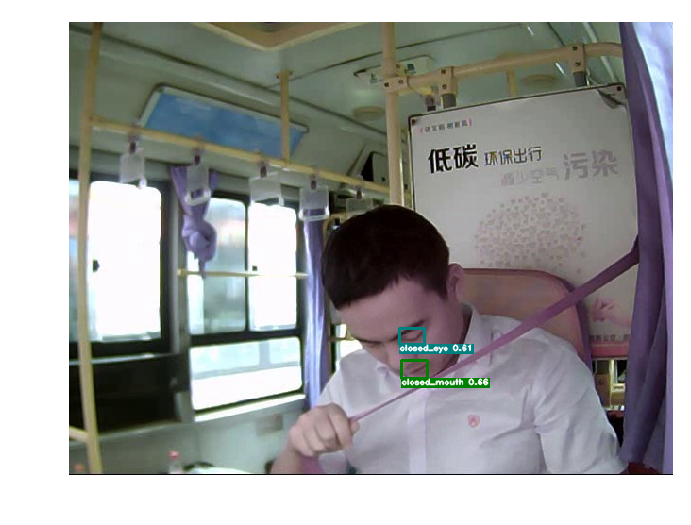

2022-02-23 15:56:13 [INFO]	The visualized result is saved at ./output/ppyolov2_r50vd_dcn/predict/visualize_715.jpg


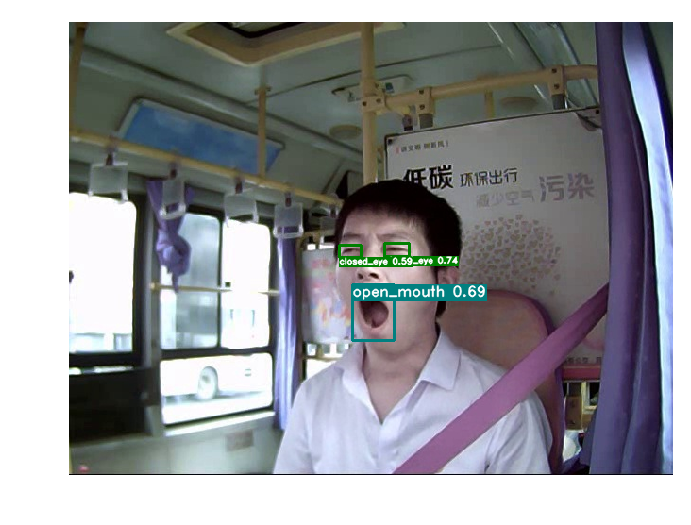

In [12]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import cv2
import paddlex as pdx

#模型测试
model = pdx.load_model('output/ppyolov2_r50vd_dcn/best_model')

image_names = ['Dataset/dataset/JPEGImages/30.jpg',
            'Dataset/dataset/JPEGImages/715.jpg'
            ]


#展示测试结果
for image_name in image_names:
    result = model.predict(image_name)


    pdx.det.visualize(image_name, result, threshold=0.5, save_dir='./output/ppyolov2_r50vd_dcn/predict')

  
    img=pdx.det.visualize(image_name, result, threshold=0.5, save_dir=None)
 
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax=plt.subplots(dpi=150)
    plt.imshow(img_rgb)
    plt.axis('off') 
    plt.show()


In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 